In [36]:
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle
from keras.models import load_model
from imutils import paths
from helper import resize_to_fit
import numpy as np
import matplotlib.pyplot as plt

model_name = 'captcha_model.hdf5'
model_labels = 'model_label.dat'

In [37]:
#Loads the model from the disk
model = load_model(model_name)

In [38]:
#load the transformer with the tags
with open(model_labels, 'rb') as f:
    lb = pickle.load(f)

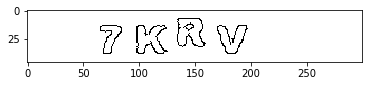

In [39]:
#Loads the image from the disk
image = cv2.imread('test.png')

#changes the aspect ratio of the image
resized = imutils.resize(image.copy(), width=300)

#puts the image in grayscale for latter use in the model
gray = cv2.cvtColor(resized.copy(), cv2.COLOR_BGR2GRAY)

#applies a blur to make the image
blurred = cv2.GaussianBlur(resized, (9, 9), 0)

#gets the edges of the image
edges = cv2.Canny(blurred, 75, 200)
plt.imshow(edges, cmap=plt.cm.binary)

#looks for contours
cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output = resized.copy()

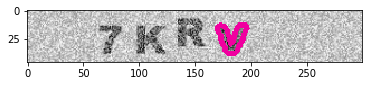

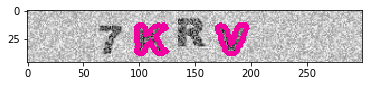

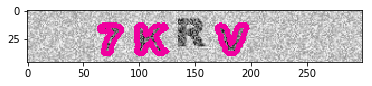

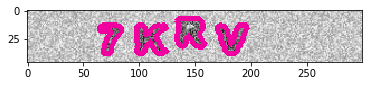

In [40]:
letter_image_regions = []

for cnt in cnts:
    cv2.drawContours(output, [cnt], -1, (240, 0, 159),3)
    (x, y, w, h) = cv2.boundingRect(cnt)
    #Verifies that a contour is not to big
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))    
    plt.imshow(output,cmap =plt.cm.binary)
    plt.show()
#puts the contours in order
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

In [41]:
#eliminitates a contour if its to small
for coordenates in letter_image_regions:
    if coordenates[2]<20 or coordenates[3]<25:
        letter_image_regions.remove(coordenates)        

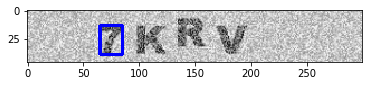

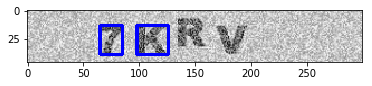

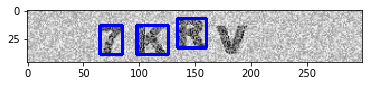

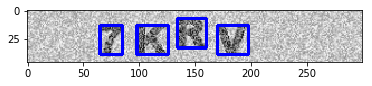

In [42]:
for region in letter_image_regions:
    start_point = (region[0], region[1])
    final_point = (region[0]+region[2], region[1]+region[3])
    cv2.rectangle(resized, start_point, final_point, (0,0,255), 2)   
    plt.imshow(resized, cmap=plt.cm.binary)
    plt.show()


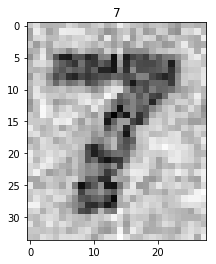

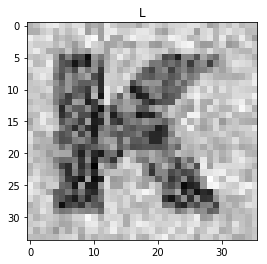

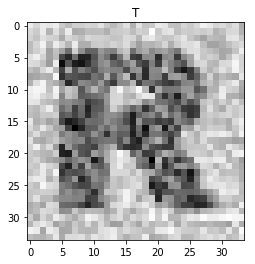

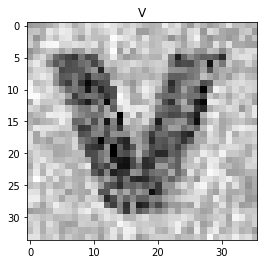

The captcha text is: 7LTV


In [43]:
# this list will save the predictions
predictions = []

for letter in letter_image_regions:
    x, y, w, h = letter
    #extracts the letter of the image with a 4 pixel margin
    
    letter = gray[y - 4:y + h + 4, x - 4:x + w + 4]        
    plt.imshow(letter, cmap='gray')
    #rescales the image to make it 20x20, the size the model takes in
    letter = resize_to_fit(letter, 20,20)
    #turns the image into a 4d tensor    
    letter = np.expand_dims(letter, axis=2)    
    letter = np.expand_dims(letter, axis=0)    
    #forwards the image to the neuralnet
    prediction = model.predict([letter])
    #reverts the image to a one-hot vector
    prediction = lb.inverse_transform(prediction)[0]
   
    plt.title(prediction)
    plt.show()
    predictions.append(prediction)
    
#needs better training data...
captcha = "".join(predictions)
print(f"The captcha text is: {captcha}")